# Multiparticle Localization

We will build a UNet to detect and locate multiple quantum dots in fluorescence images.

In [1]:
# from deeptrack import Dataset

# dataset = Dataset("detection_quantumdots", split="train", shuffle_files=False)
# print("Size:", dataset.size)

# from PIL import Image

# for i in range(4):
#     im = next(iter(dataset)).squeeze()
#     im = Image.fromarray(im)
#     im.save("./frame_" + str(i) + ".tif")

## Quantum dot movie frames

We will use a few frames from a video of quantum dots labeling a membrane protein in the membrane of living cells.

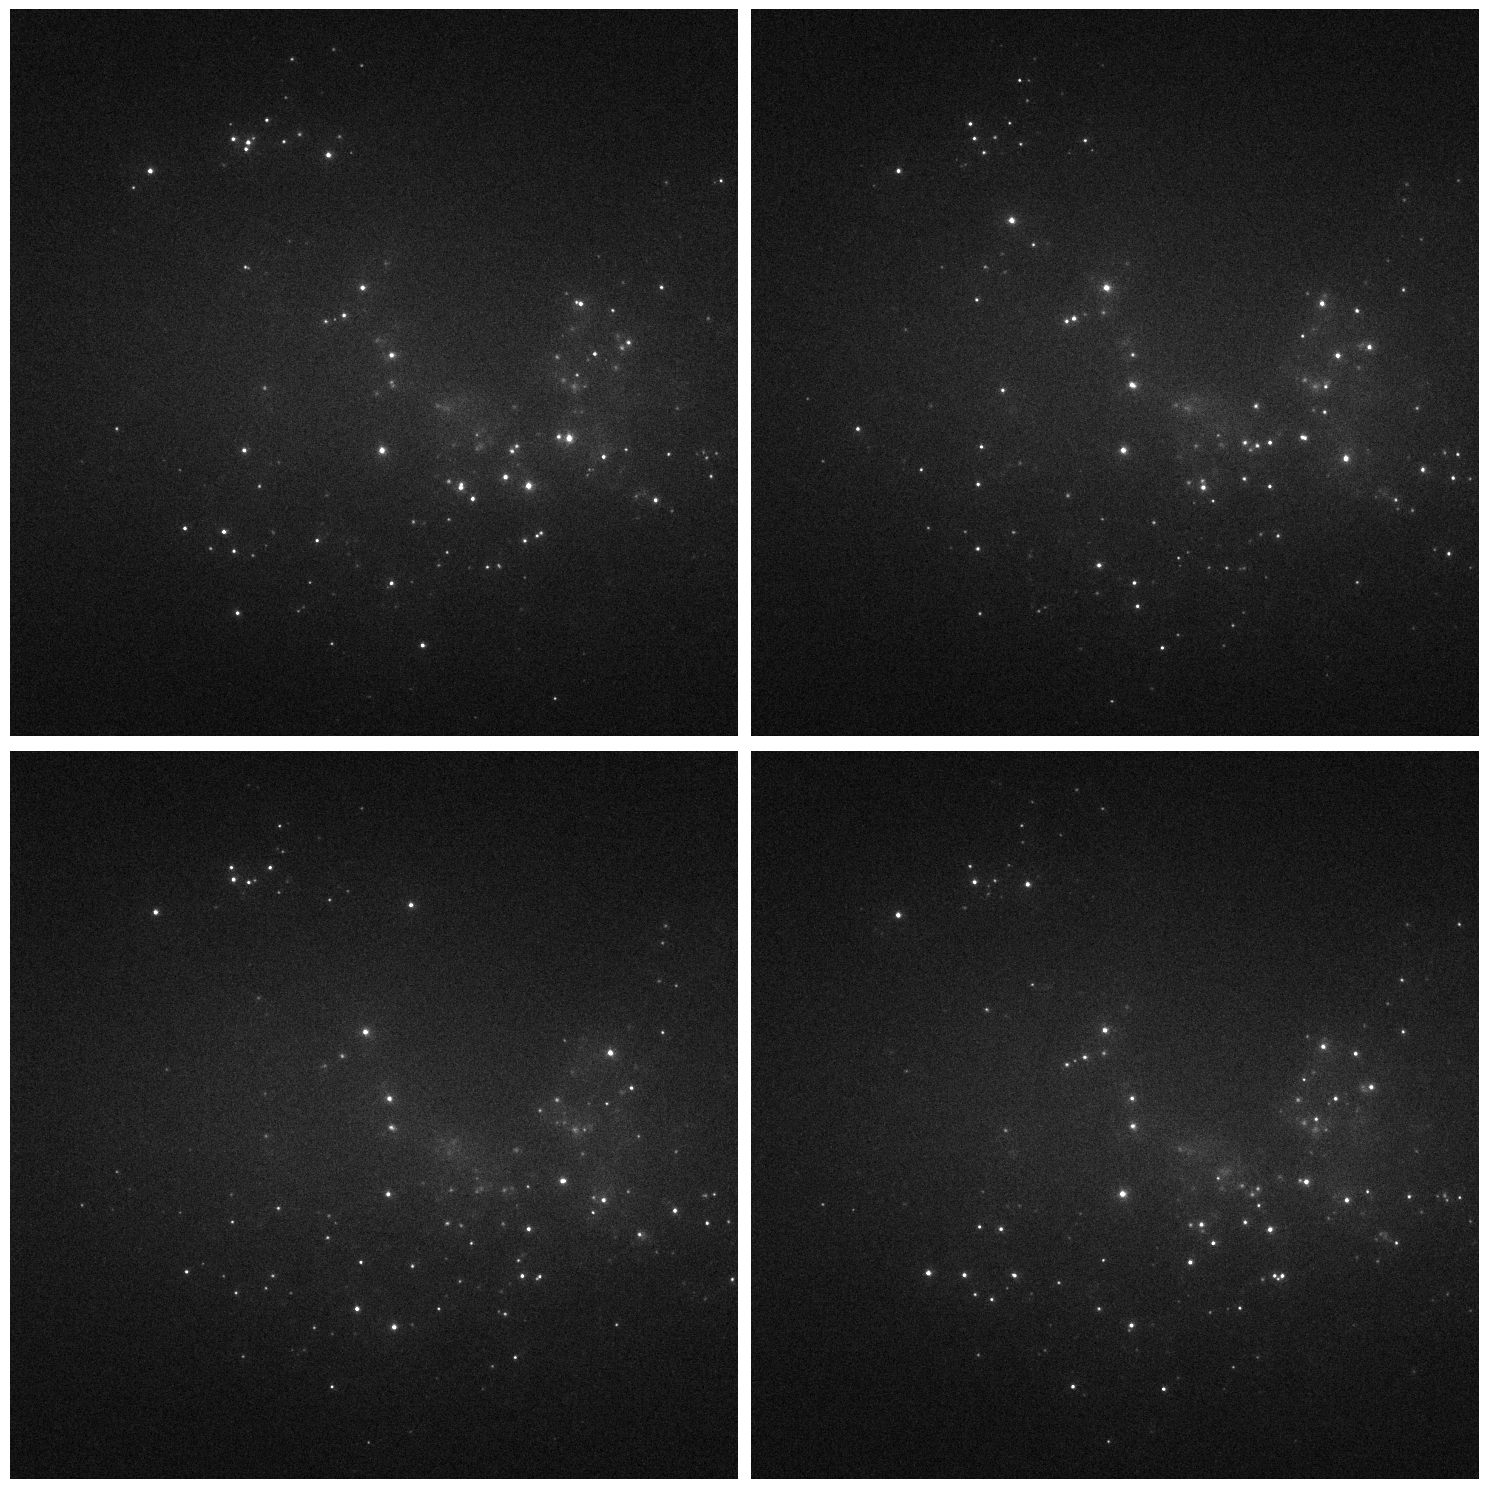

In [2]:
from PIL import Image
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 15))
for i in range(4):
    image_of_particle = Image.open("./frame_" + str(i) + ".tif")
    plt.subplot(2, 2, i + 1)
    plt.imshow(image_of_particle, vmin=100, vmax=200, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

We'll focus on an individual quantum dot appearing in the first frame. 

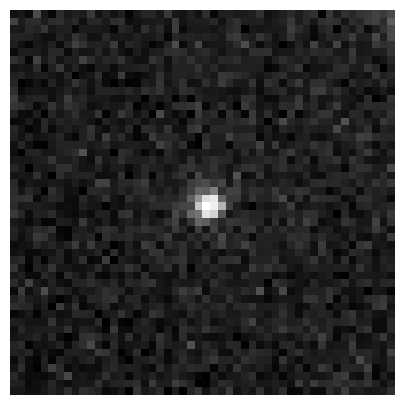

In [3]:
pos_x, pos_y = 178, 271
crop_size = 50
raw_image = Image.open("./frame_0.tif")
crop = raw_image.crop((pos_x, pos_y, pos_x + crop_size, pos_y + crop_size))
plt.figure(figsize=(5, 5))
plt.imshow(crop, cmap="gray", vmin=100, vmax=200)
plt.axis("off")
plt.show()

The quantum dots have a negligible physical size with respect to the point spread function of the microscope and can thus be simulated as point emitters using `DeepTrack`. We can tune the parameters...

In [4]:
import deeptrack as dt
from numpy.random import poisson

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm,
    NA=0.9,
    magnification=1,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 50, 50),
)
particle = dt.PointParticle(position=(25, 25), intensity=1.2e4, z=0)
postprocess = dt.Add(30) >> poisson >> dt.Add(80)
simulation_pipeline = optics(particle) >> postprocess

2024-01-31 21:09:57.226529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


... and obtain simulations that quantitatively reproduce the experimental data, as we can see by comparing the images and their histograms.

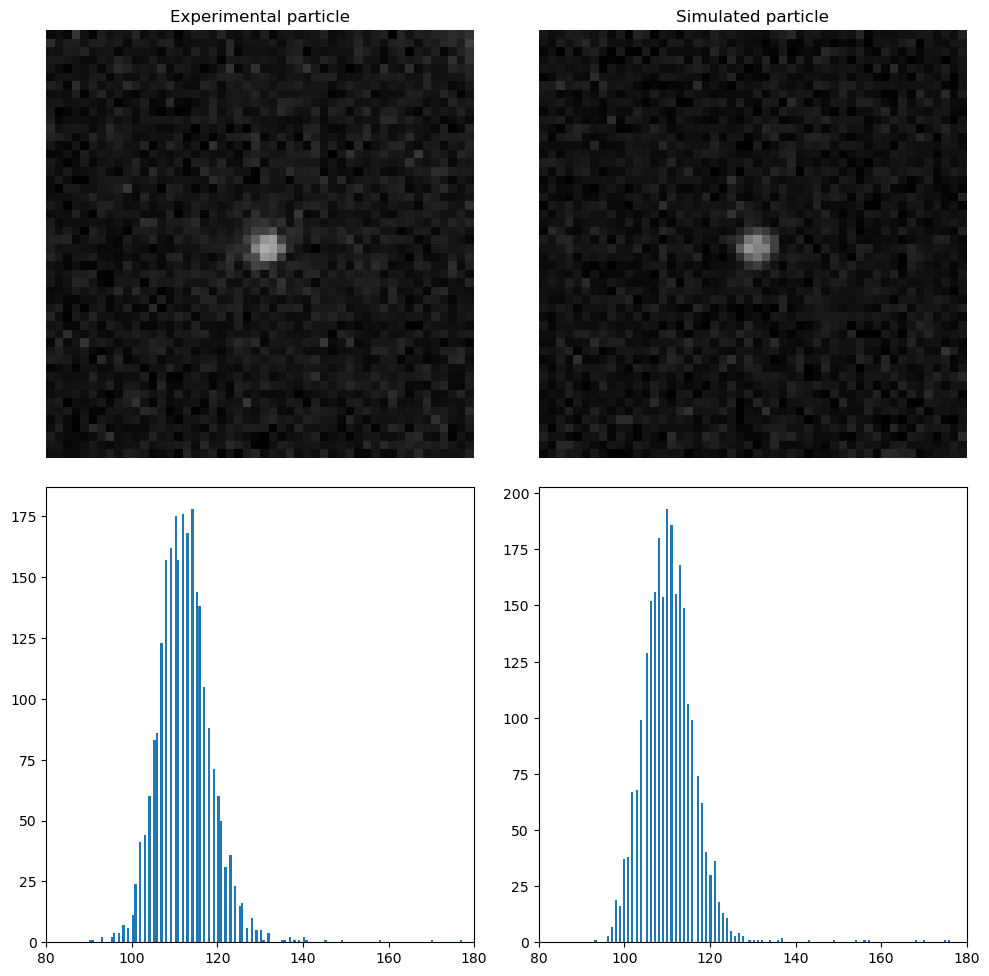

In [5]:
import numpy as np

simulated_image = simulation_pipeline.update()()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(crop, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Experimental particle")
plt.subplot(2, 2, 2)
plt.imshow(simulated_image, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Simulated particle")
plt.subplot(2, 2, 3)
plt.hist(np.array(crop).flatten(), 200)
plt.xlim([80, 180])
plt.subplot(2, 2, 4)
plt.hist(np.array(simulated_image).flatten(), 200)
plt.xlim([80, 180])
plt.tight_layout()
plt.show()

We can use these simulations parameters as a starting point to build a training dataset, in which each image contains multiple quantum dots.

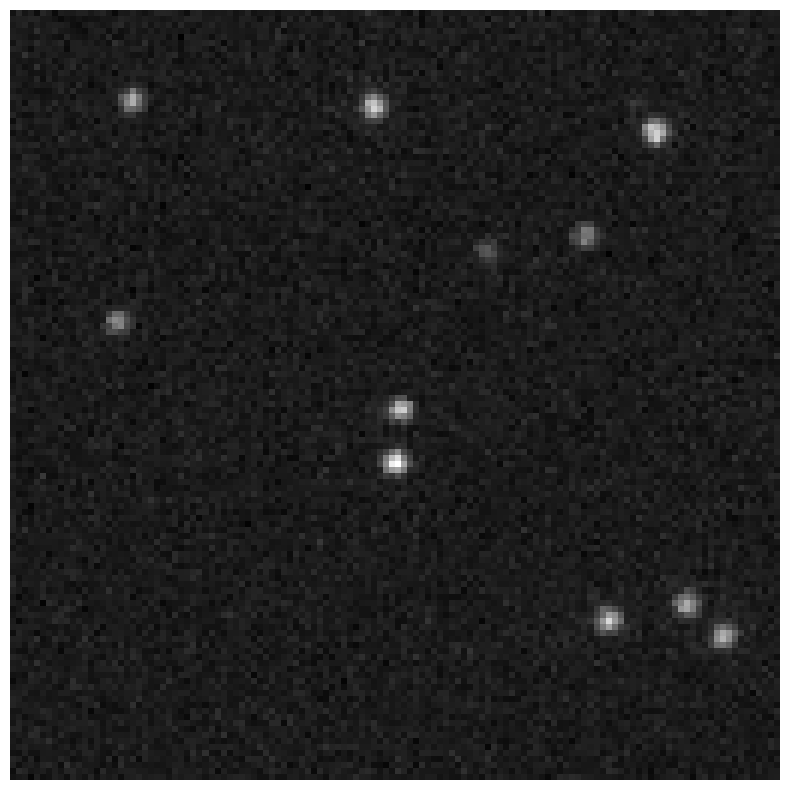

In [6]:
from numpy.random import poisson, uniform, randint
import torch

optics = dt.Fluorescence(
    NA=0.9,
    magnification=1,
    wavelength=600 * dt.units.nm,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 128, 128),
)
particle = dt.PointParticle(
    position=lambda: uniform(0, 128, size=2),
    intensity=lambda: uniform(6e3, 3e4),
    z=lambda: uniform(-0.5, 0.5) * dt.units.um,
)
postprocess = (
    dt.Add(lambda: uniform(20, 40)) >> poisson >> dt.Add(lambda: uniform(70, 90))
)
normalization = (
    dt.AsType("float") >> dt.Subtract(110) >> dt.Divide(250)
)  # >> dt.NormalizeMinMax(0, 1)
#

sample = particle ^ (lambda: randint(10, 20))
simulation_pipeline = optics(sample) >> postprocess >> normalization
image = simulation_pipeline.update()()
plt.figure(figsize=(10, 10))
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

As a target, we will use a binary map of the quantum dots locations.

In [7]:
from numpy import ones, concatenate


def map_classes(image):
    image = image.copy()
    im_out = concatenate((abs(1 - image), image), axis=-1)
    return im_out


gt_masks = (
    sample
    >> dt.SampleToMasks(
        lambda: lambda particle: particle > 0,
        output_region=optics.output_region,
        merge_method="or",
    )
    # >> dt.Multiply(100)
    >> map_classes
)

So that we can get image/map pairs through a pipeline.

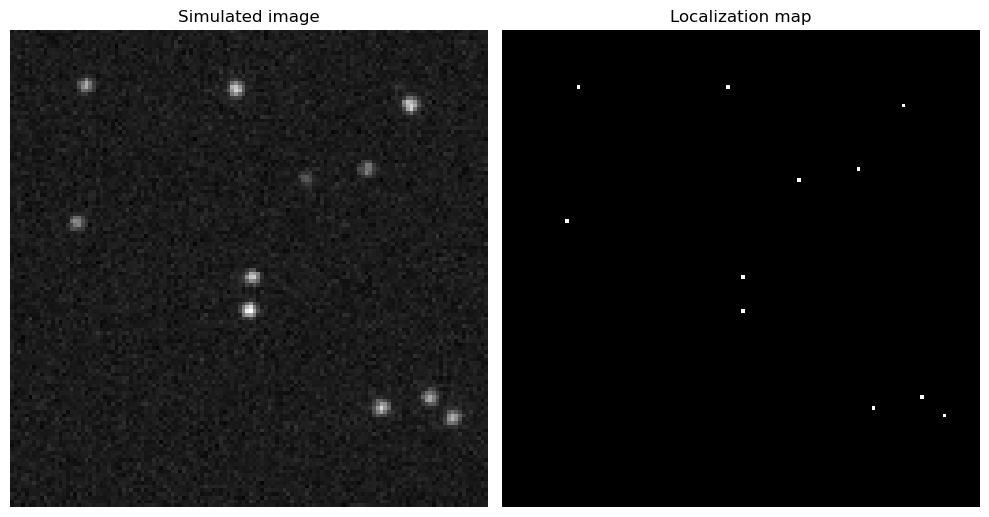

In [8]:
image_and_mask_pipeline = (
    (simulation_pipeline & gt_masks)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

simulated_image, gt_image = image_and_mask_pipeline()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(simulated_image.squeeze(), cmap="gray")
plt.axis("off")
plt.title("Simulated image")
plt.subplot(1, 2, 2)
plt.imshow(gt_image.squeeze()[1], cmap="gray")
plt.axis("off")
plt.title("Localization map")
plt.tight_layout()
plt.show()

## UNet

We implement a shallow UNet since the problem does not require a large receptive field.

In [9]:
import deeplay as dl

from torch.nn import Softmax, Sigmoid, Identity

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=2,
    # out_activation=Softmax(dim=1),
)

print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

Since the ground truth is mostly composed by zeros, we need to avoid that the loss force the network to just predict zeros, regardless of the input.
We achieve that with use a biased crossentropy loss, which punishes false negatives more harshly than false positives.

In [10]:
import torchmetrics as tm
from torch.nn import CrossEntropyLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(weight=torch.tensor([1, 10])),  # BCELoss(),  #
    optimizer=dl.Adam(),
).create()

We train it over 320 images, with a 10% probability to be replaced at each iteration, for 50 epochs. 

In [11]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(image_and_mask_pipeline, length=320, replace=0.1)
data_loader = DataLoader(train_dataset, batch_size=32)
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")

unet_trainer.fit(unet_regressor, data_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


We test the results over the first frame of the quantum dots movie. 

(-0.5, 127.5, 127.5, -0.5)

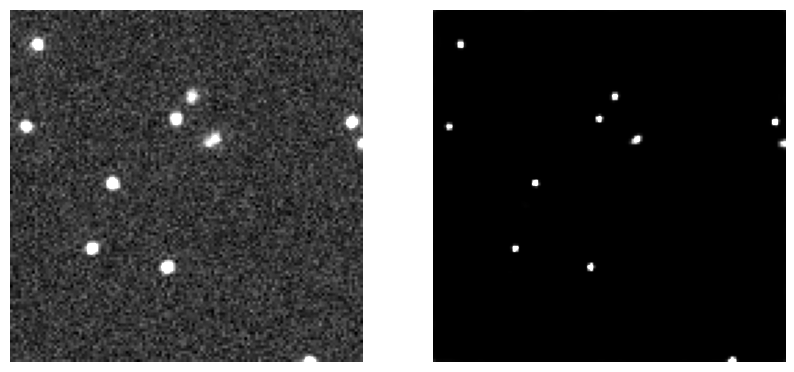

In [12]:
from torch.nn import LogSoftmax

raw_image, _ = image_and_mask_pipeline.update()()
raw_image = raw_image.unsqueeze(0)

pred = unet_regressor(raw_image).detach()
pred = torch.nn.functional.softmax(pred, dim=1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(raw_image.squeeze(), vmin=0, vmax=0.3, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze()[1], vmin=0, vmax=0.5, cmap="gray")
plt.axis("off")

In [13]:
from numpy import array
from skimage.measure import label, regionprops
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment


def mask_to_positions(mask):
    # label the mask
    labels = label(mask)
    # get centroids
    props = regionprops(labels)
    return array([prop.centroid for prop in props])


def match_positions(predicted_positions, true_positions, max_distance=2):
    # predicted_positions: [n, 2]
    # true_positions: [m, 2]
    # return: (k,) (k,), where k is the number of matches
    if len(predicted_positions) == 0 or len(true_positions) == 0:
        return [], []
    # compute distance matrix
    d_matrix = distance_matrix(predicted_positions, true_positions)
    # find the closest true position for each predicted position
    row_indices, col_indices = linear_sum_assignment(d_matrix)
    # filter out matches that are too far away
    too_far = d_matrix[row_indices, col_indices] > max_distance
    row_indices = row_indices[~too_far]
    col_indices = col_indices[~too_far]
    return row_indices, col_indices


def true_positives(n_predictions, n_labels, n_matches):
    return n_matches


def false_positives(n_predictions, n_labels, n_matches):
    return n_predictions - n_matches


def false_negatives(n_predictions, n_labels, n_matches):
    return n_labels - n_matches

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/contour.py:1471: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=np.float64)


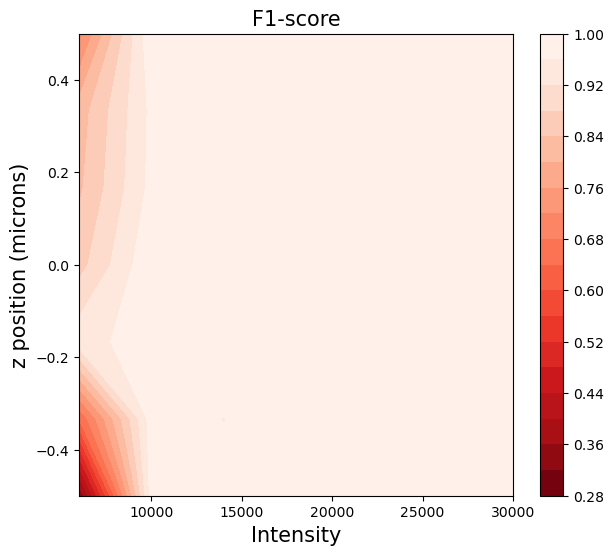

In [14]:
from numpy import linspace, zeros, newaxis

NUMBER_OF_BINS = 7
IMAGES_PER_BIN = 5
z_range = linspace(-0.5, 0.5, NUMBER_OF_BINS) * dt.units.um
intensity_range = linspace(6e3, 3e4, NUMBER_OF_BINS)
TP_mat = zeros((len(z_range), len(intensity_range)))
FP_mat = zeros((len(z_range), len(intensity_range)))
FN_mat = zeros((len(z_range), len(intensity_range)))
total_iterations = NUMBER_OF_BINS**2 * IMAGES_PER_BIN
for iteration in range(total_iterations):
    print(f"Image {iteration+1}/{total_iterations}", end="\r")
    index = iteration // IMAGES_PER_BIN
    z_index = index // NUMBER_OF_BINS
    intensity_index = index % NUMBER_OF_BINS
    # Generate image
    image_and_mask_pipeline.update()
    image_of_particle, gt_mask = image_and_mask_pipeline(
        z=z_range[z_index], intensity=intensity_range[intensity_index]
    )
    # Predict mask
    predicted_mask = unet_regressor(image_of_particle.unsqueeze(0)).detach()
    predicted_mask = torch.nn.functional.softmax(predicted_mask, dim=1)
    # Compute metrics
    predicted_positions = mask_to_positions(predicted_mask[0, 1, ...] > 0.5)
    gt_positions = mask_to_positions(gt_mask[1, ...] > 0.5)
    row_indices, col_indices = match_positions(predicted_positions, gt_positions)
    n_predictions = len(predicted_positions)
    n_labels = len(gt_positions)
    n_matches = len(row_indices)
    TP = true_positives(n_predictions, n_labels, n_matches)
    FN = false_negatives(n_predictions, n_labels, n_matches)
    TP_mat[z_index, intensity_index] += TP
    FN_mat[z_index, intensity_index] += FN
F1_mat = 2 * TP_mat / (2 * TP_mat + FP_mat + FN_mat)
plt.figure(figsize=(7, 6))
plt.contourf(intensity_range, z_range, F1_mat, levels=20, cmap="Reds_r")
plt.colorbar()
plt.title("F1-score", fontsize=15)
plt.xlabel("Intensity", fontsize=15)
plt.ylabel("z position (microns)", fontsize=15)
plt.show()

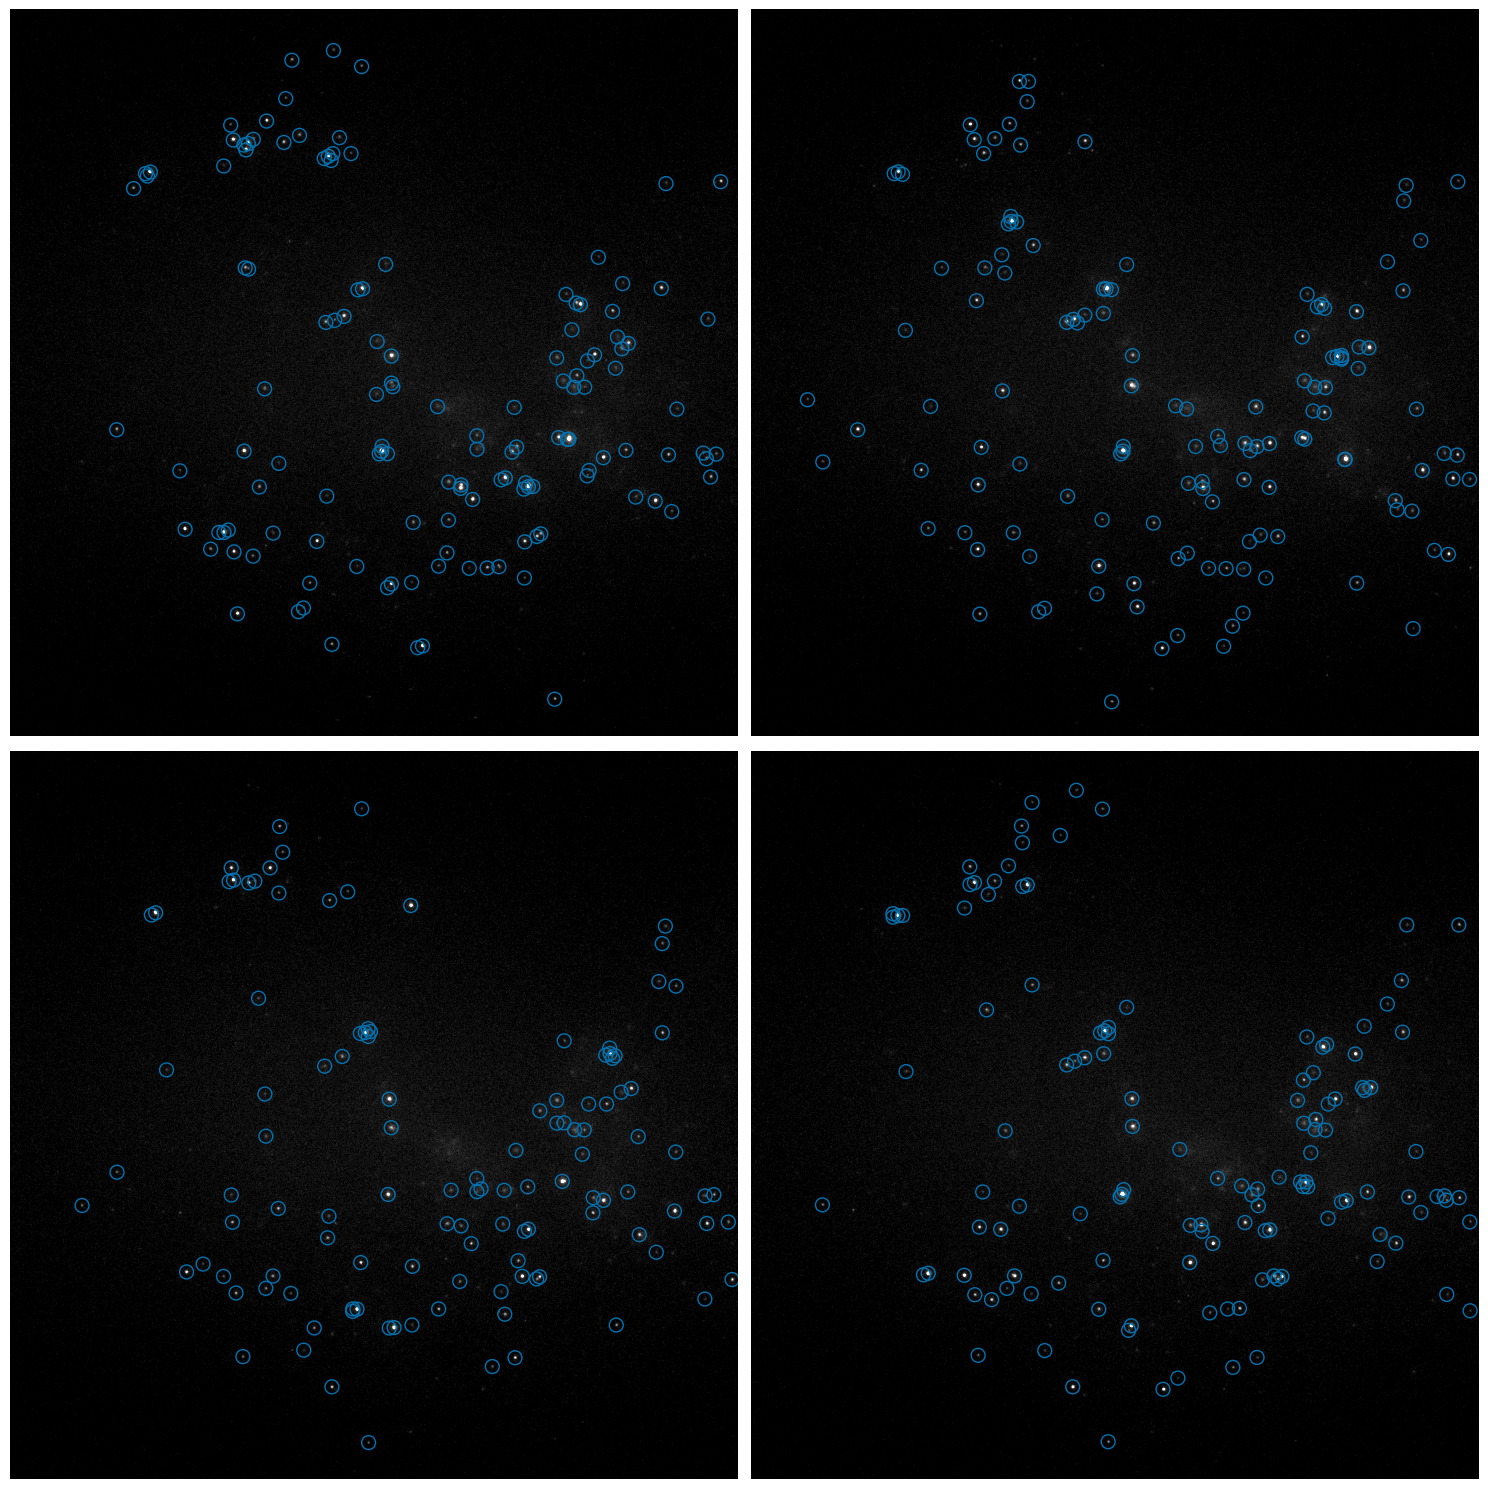

In [15]:
scatter_color = (0.0039, 0.45, 0.70)
# normalized_dataset = dataset >> normalization


plt.figure(figsize=(15, 15))
for idx in range(4):
    image_of_particle = Image.open("./frame_" + str(idx) + ".tif")
    image_of_particle = (np.array(image_of_particle).astype(np.float32) - 110) / 250
    image_of_particle = torch.from_numpy(image_of_particle).unsqueeze(0)

    predicted_mask = unet_regressor(image_of_particle.unsqueeze(0)).detach()
    predicted_mask = torch.nn.functional.softmax(predicted_mask, dim=1)

    positions = mask_to_positions(predicted_mask[0, 1, ...] > 0.5)
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image_of_particle[0, ...], vmin=0, vmax=0.5, cmap="gray")
    plt.scatter(
        positions[:, 1],
        positions[:, 0],
        100,
        facecolors="none",
        edgecolors=scatter_color,
    )
    plt.axis("off")
plt.tight_layout()
plt.show()